In [5]:
!python --version

Python 3.10.11


In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
print(tf.__version__)

2.17.0


In [8]:
def show_one_image_per_class(data_dir, classes, img_size=(224, 224)):
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 20))
    for ax, class_name in zip(axes, classes):
        class_dir = os.path.join(data_dir, class_name)
        img_name = os.listdir(class_dir)[0]  # Get the first image in the directory
        img_path = os.path.join(class_dir, img_name)

        # Load and preprocess the image
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0

        # Display the image
        ax.imshow(img_array)
        ax.set_title(class_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
train_dir = 'augmented_focus/train/'
val_dir = 'augmented_focus/val/'
test_dir = 'augmented_focus/test/'

classes = ['clean', 'dusty', 'bird_drop', 'electrical_damage', 'physical_damage']

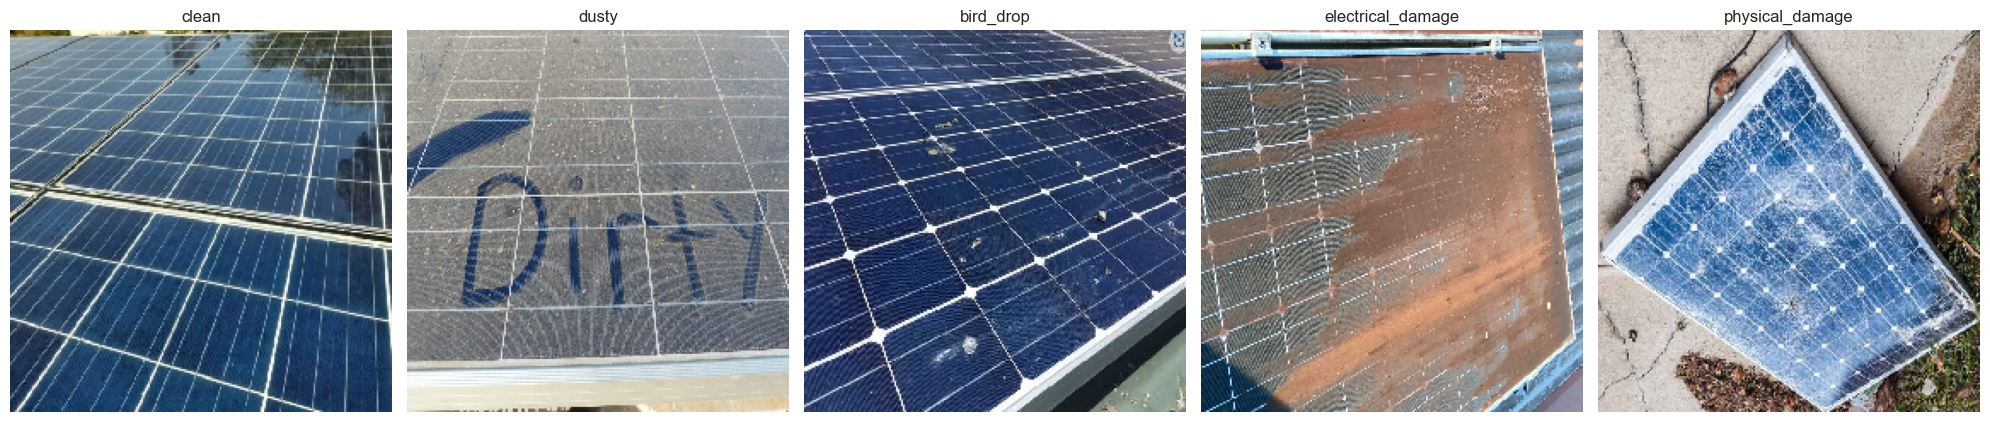

In [10]:
show_one_image_per_class(train_dir, classes)

In [11]:
# data augmentation for training and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
)
val_datagen = ImageDataGenerator(rescale=1.0/255.0,)
test_datagen = ImageDataGenerator(rescale=1.0/255.0,)

# generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=64,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,      
    target_size=(224, 224), 
    batch_size=64,
    class_mode='categorical',
    shuffle=False           
)

Found 814 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 106 images belonging to 5 classes.


In [12]:
# Directory to save the best models
save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Directory to save the model summaries
model_summary_dir = 'model_summaries'
if not os.path.exists(model_summary_dir):
    os.makedirs(model_summary_dir)

# Directory to save the model architecture plots
plot_dir = 'model_architecture_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Directory to save accuracy and loss plots
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Directory to save the training history CSV files
history_dir = 'training_histories'
if not os.path.exists(history_dir):
    os.makedirs(history_dir)

# Directory to save the confusion matrices
confusion_matrix_dir = 'confusion_matrices'
if not os.path.exists(confusion_matrix_dir):
    os.makedirs(confusion_matrix_dir)

# Directory to save the classification reports
classification_report_dir = 'classification_reports'
if not os.path.exists(classification_report_dir):
    os.makedirs(classification_report_dir)

# Dictionary to store the training histories
histories = {}

In [13]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
input_shape = (224, 224, 3) # Modify this based on the base model's input shape
inputs = Input(shape=input_shape)

# Add the base model
x = base_model(inputs, training=False)  # Set training=False to avoid updating batch normalization layers

# Add additional layers
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax', kernel_regularizer=l2(0.0001))(x)

keras_model = Model(inputs, outputs)

# Compile the new model
keras_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

keras_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,995,653 (11.43 MB)

 Trainable params: 737,669 (2.81 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
model_name = 'new_MobileNetV2'

summary_file = os.path.join(model_summary_dir, f'{model_name}_summary.txt')
    
with open(summary_file, 'w', encoding='utf-8') as f:
    keras_model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    
model_checkpoint = ModelCheckpoint(
        filepath=os.path.join(save_dir, f'best_model_{model_name}.keras'),
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
)
    
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        mode='min',
        verbose=1,
        restore_best_weights=True
    )
    
model_callbacks = [model_checkpoint, early_stopping]

# Train the model
history = keras_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=20,
        callbacks=model_callbacks
    )   

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2533 - loss: 2.1517
Epoch 1: val_loss improved from inf to 1.13171, saving model to saved_models\best_model_new_MobileNetV2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 0.2591 - loss: 2.1255 - val_accuracy: 0.6500 - val_loss: 1.1317
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4899 - loss: 1.2131
Epoch 2: val_loss improved from 1.13171 to 0.85901, saving model to saved_models\best_model_new_MobileNetV2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.4932 - loss: 1.2082 - val_accuracy: 0.7900 - val_loss: 0.8590
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6377 - loss: 0.9668
Epoch 3: val_loss improved from 0.85901 to 0.67064, saving model to saved_models\best_model_new_MobileNetV2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6376 - loss: 0.9660 - val_accuracy: 0.8300 - val_loss: 0.6706
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6624 

------------------------------
You must install pydot (`pip install pydot`) for `plot_model` to work.
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step


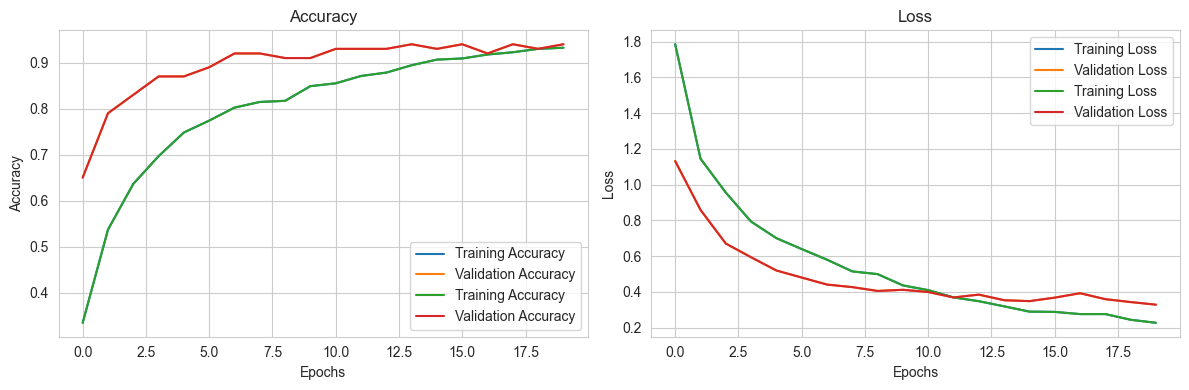

TensorFlow Keras models have been saved in the directory: saved_models
Training histories have been saved in the directory: training_histories
Model architectures have been saved in the directory: model_architecture_plots
Confusion matrices have been saved in the directory: confusion_matrices
Classification reports have been saved in the directory: classification_reports
Model summaries have been saved in the directory: model_summaries
Accuracy and loss plots have been saved in the directory: plots


In [16]:
# Save the training history
histories[model_name] = history.history
    
# Save the history to CSV
history_df = pd.DataFrame(history.history)
history_csv_file = os.path.join(history_dir, f'{model_name}_history.csv')
history_df.to_csv(history_csv_file, index=False)
    
print("-" * 30)
    
# Plot the model architecture and save as an image file
plot_file = os.path.join(plot_dir, f'{model_name}.png')
plot_model(keras_model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Generate confusion matrix
y_pred = np.argmax(keras_model.predict(test_generator), axis=-1)
y_true = test_generator.labels
cm = confusion_matrix(y_true, y_pred)
    
# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
cm_file = os.path.join(confusion_matrix_dir, f'{model_name}_confusion_matrix.png')
plt.savefig(cm_file)
plt.close()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=classes)
report_file = os.path.join(classification_report_dir, f'{model_name}_classification_report.txt')
with open(report_file, 'w', encoding='utf-8') as f:
    f.write(report)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
    
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


metrics = ['accuracy', 'loss']
for i, metric in enumerate(metrics):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.title(f'{metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{metric.capitalize()}')
    plt.legend()
    
plt.tight_layout() 
plt.show()

    
# Save the plot
plot_acc_loss_file = os.path.join(plots_dir, f'{model_name}_accuracy_loss.png')
plt.savefig(plot_acc_loss_file)
plt.close()

print(f"TensorFlow Keras models have been saved in the directory: {save_dir}")
print(f"Training histories have been saved in the directory: {history_dir}")
print(f"Model architectures have been saved in the directory: {plot_dir}")
print(f"Confusion matrices have been saved in the directory: {confusion_matrix_dir}")
print(f"Classification reports have been saved in the directory: {classification_report_dir}")
print(f"Model summaries have been saved in the directory: {model_summary_dir}")
print(f"Accuracy and loss plots have been saved in the directory: {plots_dir}")

In [17]:
# Load the best model
best_model = tf.keras.models.load_model(os.path.join(save_dir, f'best_model_{model_name}.keras'))

In [18]:
# get the model classes and indices
class_indices = train_generator.class_indices
class_indices

{'bird_drop': 0,
 'clean': 1,
 'dusty': 2,
 'electrical_damage': 3,
 'physical_damage': 4}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


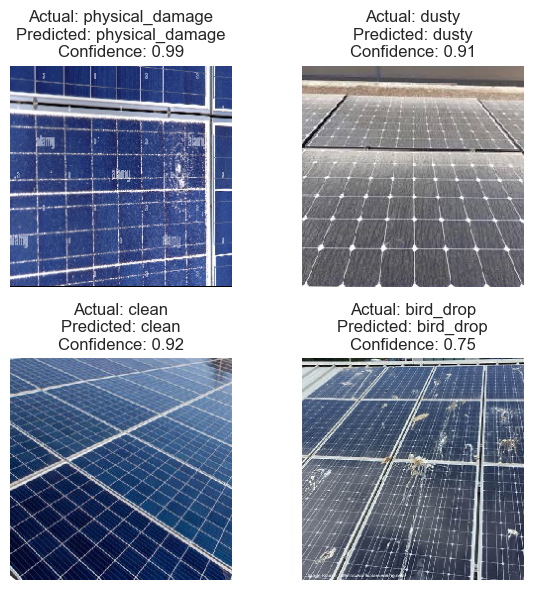

In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define the class names
class_names = ['bird_drop', 'clean', 'dusty', 'electrical_damage', 'physical_damage']

# Preprocessing function
def preprocess_images(img_paths):
    images = []
    for img_path in img_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize the image data to [0, 1]
        images.append(img_array)
    return np.vstack(images)  # Stack all images into a single array

# Example image paths and actual labels
img_paths = ['crack.png', 'Dust (90).jpg', 'Cleaan (159).jpg', 'Bird (9).jpg']
actual_labels = ['physical_damage', 'dusty', 'clean', 'bird_drop']

input_data = preprocess_images(img_paths)
predictions = keras_model.predict(input_data)
predicted_indices = np.argmax(predictions, axis=1)
predicted_classes = [class_names[idx] for idx in predicted_indices]

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
for i, (img_path, ax) in enumerate(zip(img_paths, axs.flatten())):
    img = image.load_img(img_path, target_size=(224, 224))
    ax.imshow(img)
    
    confidence = predictions[i][predicted_indices[i]]
    title = (f"Actual: {actual_labels[i]}\n"
             f"Predicted: {predicted_classes[i]}\n"
             f"Confidence: {confidence:.2f}")
    
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()